In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [3]:
mask_100206_long_pro = process_data.get_mask_pro(scan_100206, mask_100206)

In [4]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [93]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 5))

In [94]:
rand_sub_bval_indice_100206

array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 176, 177, 178, 179, 180, 181, 182, 183,
       184, 185, 186, 187, 188, 189, 190, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271])

In [95]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [96]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [97]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [98]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [99]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

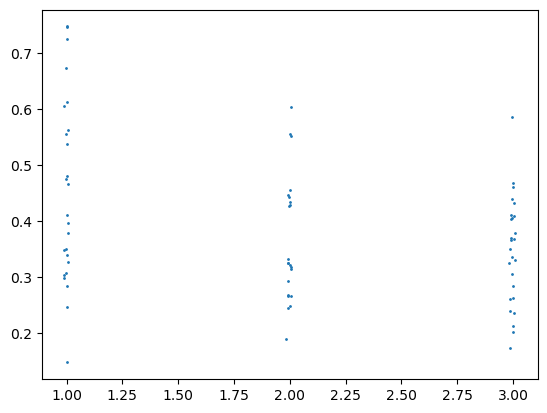

In [100]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

ANN

In [49]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [50]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [51]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 5))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        X = volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso)
        return X, theta, phi, mu_cart, lambda_par, lambda_iso, volume_0, volume_1

In [101]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [102]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(73, 3)


In [103]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [104]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [107]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.01it/s]


Loss: 400.2963368196506
Average Loss: 0.054775087140072606
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 311.25it/s]


Loss: 400.13244631909765
Average Loss: 0.054752660963204386
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 306.72it/s]


Loss: 400.22575383470394
Average Loss: 0.05476542882248275
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.68it/s]


Loss: 399.9367303350009
Average Loss: 0.0547258799035305
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.92it/s]


Loss: 399.84999356023036
Average Loss: 0.05471401116040372
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.74it/s]


Loss: 399.7604893015232
Average Loss: 0.05470176372489371
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.29it/s]


Loss: 400.0115149784833
Average Loss: 0.054736113160712
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.61it/s]


Loss: 399.8434107089415
Average Loss: 0.05471311038710201
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.64it/s]


Loss: 399.8313521814998
Average Loss: 0.05471146034229609
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.80it/s]


Loss: 399.791994207073
Average Loss: 0.05470607474097879
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 4


  2%|██▉                                                                                                                                                           | 136/7308 [00:02<00:54, 131.67it/s]

X_batch: 
torch.Size([128, 73])
tensor([[0.4663, 0.1839, 0.2043,  ..., 0.4886, 0.1664, 0.3053],
        [0.1523, 0.0750, 0.0738,  ..., 0.1467, 0.0783, 0.0970],
        [0.5128, 0.2898, 0.2171,  ..., 0.5750, 0.2534, 0.3883],
        ...,
        [1.0586, 0.7944, 1.2113,  ..., 1.1576, 0.9134, 1.1219],
        [0.5410, 0.8126, 0.2901,  ..., 0.8746, 0.5818, 0.7211],
        [0.4447, 0.5389, 0.1639,  ..., 0.4610, 0.2114, 0.1506]])
X_pred: 
torch.Size([128, 73])
tensor([[0.4781, 0.1998, 0.1797,  ..., 0.4865, 0.1764, 0.2971],
        [0.1716, 0.0895, 0.0917,  ..., 0.1719, 0.0896, 0.1107],
        [0.5435, 0.1980, 0.2050,  ..., 0.5527, 0.1936, 0.3758],
        ...,
        [0.8491, 0.7080, 0.7054,  ..., 0.8538, 0.6976, 0.8077],
        [0.6885, 0.4967, 0.5722,  ..., 0.6872, 0.5492, 0.6393],
        [0.4645, 0.3824, 0.1659,  ..., 0.4306, 0.2034, 0.2340]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.10it/s]


Loss: 399.74698060844094
Average Loss: 0.054699915244723715
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.19it/s]


Loss: 399.4598895863164
Average Loss: 0.05466063075893766
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.78it/s]


Loss: 399.8922653258778
Average Loss: 0.05471979547425805
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.17it/s]


Loss: 399.42294875439256
Average Loss: 0.05465557591056275
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 280.24it/s]


Loss: 399.44133220845833
Average Loss: 0.05465809143520229
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.41it/s]


Loss: 399.7575201482978
Average Loss: 0.054701357436822355
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 270.70it/s]


Loss: 399.268564197002
Average Loss: 0.0546344504922006
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.94it/s]


Loss: 399.28730931691825
Average Loss: 0.05463701550587278
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 281.02it/s]


Loss: 399.5585930244997
Average Loss: 0.05467413697653253
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.93it/s]


Loss: 399.34659743565135
Average Loss: 0.05464512827526702
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.31it/s]


Loss: 399.3342232068535
Average Loss: 0.054643435031041805
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.51it/s]


Loss: 399.25830535800196
Average Loss: 0.05463304671018089
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.57it/s]


Loss: 399.13659926783293
Average Loss: 0.05461639289379214
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.22it/s]


Loss: 399.26233313884586
Average Loss: 0.054633597856984926
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.39it/s]


Loss: 399.0510516613722
Average Loss: 0.05460468687210895
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.20it/s]


Loss: 399.03149148100056
Average Loss: 0.054602010328544136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.94it/s]


Loss: 399.1016547125764
Average Loss: 0.05461161120861746
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.70it/s]


Loss: 399.0582100406755
Average Loss: 0.05460566639855986
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 278.32it/s]


Loss: 399.23922522063367
Average Loss: 0.054630435853945496
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.44it/s]


Loss: 398.7999656442553
Average Loss: 0.05457032917956421
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.91it/s]


Loss: 398.71693885396235
Average Loss: 0.05455896809714865
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 279.73it/s]


Loss: 399.0777806940023
Average Loss: 0.054608344375205564
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 281.87it/s]


Loss: 398.9046618801076
Average Loss: 0.05458465542968084
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.55it/s]


Loss: 399.0390377980657
Average Loss: 0.05460304293897998
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.37it/s]


Loss: 398.7256420652848
Average Loss: 0.054560159012764745
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 250.70it/s]


Loss: 398.78665868844837
Average Loss: 0.05456850830438538
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:22<00:00, 318.05it/s]


Loss: 398.8354461162817
Average Loss: 0.054575184197630223
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.90it/s]


Loss: 398.7136819071602
Average Loss: 0.05455852242845651
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.24it/s]


Loss: 398.5682459839154
Average Loss: 0.05453862150847228
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.69it/s]


Loss: 398.71316280029714
Average Loss: 0.05455845139577137
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.66it/s]


Loss: 398.53277215198614
Average Loss: 0.05453376739901288
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.14it/s]


Loss: 398.5789529432077
Average Loss: 0.05454008660963433
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.04it/s]


Loss: 398.6520496257581
Average Loss: 0.05455008889241353
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 268.75it/s]


Loss: 398.5108056112658
Average Loss: 0.054530761577896256
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.97it/s]


Loss: 398.45543060079217
Average Loss: 0.05452318426392887
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.36it/s]


Loss: 398.3581391396001
Average Loss: 0.05450987125610291
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 259.89it/s]


Loss: 398.54405099432915
Average Loss: 0.05453531075456064
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 265.68it/s]


Loss: 398.64583613630384
Average Loss: 0.05454923866123479
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.36it/s]


Loss: 398.5572376816999
Average Loss: 0.0545371151726464
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 264.13it/s]


Loss: 398.4009666875936
Average Loss: 0.05451573162118139
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.70it/s]


Loss: 398.33631381369196
Average Loss: 0.05450688475830487
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 257.62it/s]


Loss: 398.5006610141136
Average Loss: 0.0545293734283133
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.44it/s]


Loss: 398.44625474861823
Average Loss: 0.05452192867386675
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:29<00:00, 244.37it/s]


Loss: 398.5123560009524
Average Loss: 0.05453097372755233
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.80it/s]


Loss: 398.26402221107855
Average Loss: 0.05449699263972066
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.29it/s]


Loss: 398.4489242185373
Average Loss: 0.05452229395437018
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 272.31it/s]


Loss: 398.24709458695725
Average Loss: 0.05449467632552781
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 260.35it/s]


Loss: 398.3144346231129
Average Loss: 0.05450389088986219
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.49it/s]


Loss: 398.2782724520657
Average Loss: 0.05449894259059465
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.90it/s]


Loss: 398.2147987256758
Average Loss: 0.05449025707795235
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.91it/s]


Loss: 398.3512573076878
Average Loss: 0.054508929571385846
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 274.53it/s]


Loss: 398.23009356553666
Average Loss: 0.054492349967916895
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 273.84it/s]


Loss: 398.170530162286
Average Loss: 0.05448419952959579
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.73it/s]


Loss: 398.40862769051455
Average Loss: 0.05451677992481042
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.38it/s]


Loss: 398.09104566881433
Average Loss: 0.054473323162125664
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.57it/s]


Loss: 398.2528150815051
Average Loss: 0.054495459097086085
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.67it/s]


Loss: 398.23762943572365
Average Loss: 0.05449338114884013
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 275.39it/s]


Loss: 398.2252340244595
Average Loss: 0.05449168500608367
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 263.84it/s]


Loss: 398.1116950782016
Average Loss: 0.05447614875180646
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 256.84it/s]


Loss: 398.2217884021811
Average Loss: 0.054491213519729215
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 240.82it/s]


Loss: 397.95062101911753
Average Loss: 0.05445410796649118
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 255.61it/s]


Loss: 398.1805234448984
Average Loss: 0.05448556697385036
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.52it/s]


Loss: 398.21430477593094
Average Loss: 0.05449018948767528
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 267.84it/s]


Loss: 398.01694312668405
Average Loss: 0.05446318324119924
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 282.96it/s]


Loss: 398.0607916438021
Average Loss: 0.05446918331195978
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.50it/s]


Loss: 397.90493119182065
Average Loss: 0.05444785593757809
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 276.82it/s]


Loss: 397.98422372317873
Average Loss: 0.05445870603765445
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 284.02it/s]


Loss: 397.9778003904503
Average Loss: 0.05445782709228931
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.56it/s]


Loss: 398.1575455914717
Average Loss: 0.05448242276840062
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.28it/s]


Loss: 397.85374513687566
Average Loss: 0.0544408518249693
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.62it/s]


Loss: 397.96170685160905
Average Loss: 0.054455624911276555
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 271.61it/s]


Loss: 397.98029797920026
Average Loss: 0.054458168853202
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 269.15it/s]


Loss: 397.92643160233274
Average Loss: 0.05445079797514132
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.50it/s]


Loss: 397.99205814069137
Average Loss: 0.05445977807070216
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 283.50it/s]


Loss: 397.8650549808517
Average Loss: 0.054442399422667175
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 293.70it/s]


Loss: 397.9386872162577
Average Loss: 0.05445247498854101
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.48it/s]


Loss: 397.9337528808974
Average Loss: 0.05445179979213155
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 292.05it/s]


Loss: 397.84708010894246
Average Loss: 0.05443993980691605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.33it/s]


Loss: 397.84166185790673
Average Loss: 0.05443919839325489
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.18it/s]


Loss: 398.04907396179624
Average Loss: 0.054467579907197076
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.03it/s]


Loss: 397.7657892452553
Average Loss: 0.0544288162623502
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 302.96it/s]


Loss: 397.9254976406228
Average Loss: 0.05445067017523574
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.19it/s]


Loss: 397.86606609332375
Average Loss: 0.05444253777960095
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 287.90it/s]


Loss: 397.8037237992976
Average Loss: 0.05443400708802649
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.02it/s]


Loss: 397.87716633314267
Average Loss: 0.05444405669583233
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.54it/s]


Loss: 397.9234302502591
Average Loss: 0.05445038728109731
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.35it/s]


Loss: 397.7653144139331
Average Loss: 0.05442875128816818
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 302.37it/s]


Loss: 397.82524717319757
Average Loss: 0.05443695226781576
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.60it/s]


Loss: 397.9038414573297
Average Loss: 0.0544477068222947
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.57it/s]


Loss: 397.63223132910207
Average Loss: 0.054410540685427215
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.65it/s]


Loss: 397.77654152177274
Average Loss: 0.05443028756455566
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.46it/s]


Loss: 397.828201695811
Average Loss: 0.05443735655388766
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.40it/s]


Loss: 397.6477247332223
Average Loss: 0.054412660746199
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 301.03it/s]


Loss: 397.8289178335108
Average Loss: 0.054437454547552104
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 285.71it/s]


Loss: 397.6933653804008
Average Loss: 0.05441890604548451
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.02it/s]


Loss: 397.60942272562534
Average Loss: 0.0544074196395218
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.30it/s]


Loss: 397.6611456426326
Average Loss: 0.054414497214372276
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.07it/s]


Loss: 397.7806182776112
Average Loss: 0.054430845412918885
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.67it/s]


Loss: 397.56120980903506
Average Loss: 0.05440082236029489
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 303.32it/s]


Loss: 397.83117196010426
Average Loss: 0.054437762993993465
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 298.77it/s]


Loss: 397.62875960441306
Average Loss: 0.05441006562731432
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 292.01it/s]


Loss: 397.5149122548755
Average Loss: 0.05439448717225993
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.91it/s]


Loss: 397.7983435173519
Average Loss: 0.05443327086991679
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 302.58it/s]


Loss: 397.5203676603269
Average Loss: 0.05439523366999547
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 302.73it/s]


Loss: 397.6480876193382
Average Loss: 0.05441271040220829
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 297.54it/s]


Loss: 397.48805184080265
Average Loss: 0.05439081169140704
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 313.65it/s]


Loss: 397.51697383541614
Average Loss: 0.05439476927140341
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 316.09it/s]


Loss: 397.77843311149627
Average Loss: 0.054430546402777266
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 309.41it/s]


Loss: 397.4822258076165
Average Loss: 0.05439001447832738
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:23<00:00, 309.69it/s]


Loss: 397.51268365513533
Average Loss: 0.05439418221881983
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.17it/s]


Loss: 397.73568395967595
Average Loss: 0.05442469676514449
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.27it/s]


Loss: 397.51224430673756
Average Loss: 0.054394122099991456
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.76it/s]


Loss: 397.66129560931586
Average Loss: 0.05441451773526489
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.12it/s]


Loss: 397.56838721456006
Average Loss: 0.05440180449022442
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 289.93it/s]


Loss: 397.44243271276355
Average Loss: 0.05438456933672189
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.00it/s]


Loss: 397.45107043441385
Average Loss: 0.054385751290970695
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 292.16it/s]


Loss: 397.5601281649433
Average Loss: 0.05440067435207215
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.43it/s]


Loss: 397.4626111476682
Average Loss: 0.054387330479976494
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 290.41it/s]


Loss: 397.597499826923
Average Loss: 0.05440578815365668
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.45it/s]


Loss: 397.32020496274345
Average Loss: 0.054367844138306434
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.43it/s]


Loss: 397.3579940693453
Average Loss: 0.054373015061486764
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.31it/s]


Loss: 397.5860777441412
Average Loss: 0.054404225197611004
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.49it/s]


Loss: 397.4963068962097
Average Loss: 0.054391941283006257
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 294.00it/s]


Loss: 397.47673309850506
Average Loss: 0.054389262876095384
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 286.66it/s]


Loss: 397.4196978157852
Average Loss: 0.05438145837654422
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 296.92it/s]


Loss: 397.41871777013876
Average Loss: 0.05438132427068128
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.91it/s]


Loss: 397.5552001479082
Average Loss: 0.05440000002023922
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 288.40it/s]


Loss: 397.4130893156398
Average Loss: 0.05438055409354677
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:25<00:00, 291.05it/s]


Loss: 397.38746929122135
Average Loss: 0.054377048343079
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 292.95it/s]

Loss: 397.39958356297575
Average Loss: 0.05437870601573286
Done, best loss: 397.32020496274345
Done


<All keys matched successfully>

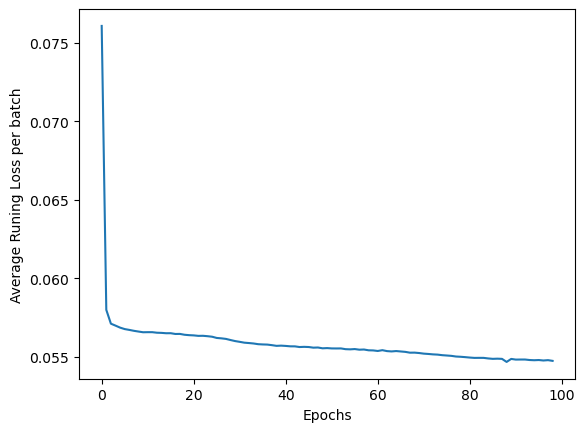

In [106]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [90]:
torch.save(final_model, 'model_100206_5g_03.pt')